In [1]:
from discretizer import discretizer
from privacy_mechanism import LapU, discLapU
import torch
device = torch.device("cpu")
import matplotlib.pyplot as plt

# testing the discretizer

In [2]:
data_conti = torch.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0.6],
    [0, 0, 0.6, 0],
    [0, 0, 0.6, 0.6],
    [0, 0.6, 0, 0],
    [0, 0.6, 0, 0.6],
    [0, 0.6, 0.6, 0],
    [0, 0.6, 0.6, 0.6],   
    [0.6, 0, 0, 0],
    [0.6, 0, 0, 0.6],
    [0.6, 0, 0.6, 0],
    [0.6, 0, 0.6, 0.6],
    [0.6, 0.6, 0, 0],
    [0.6, 0.6, 0, 0.6],
    [0.6, 0.6, 0.6, 0],
    [0.6, 0.6, 0.6, 0.6],
])
dsc = discretizer(device)
data_disc, n_category = dsc.transform(data_conti, 2)
data_disc

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

# testing the LapU for discrete data

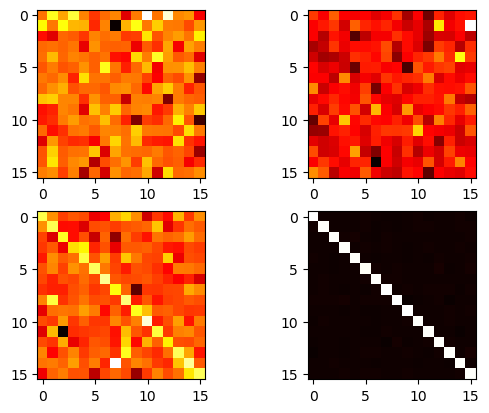

In [3]:
laputest = LapU(device)
fig, axs = plt.subplots(2,2)
axs[0,0].imshow(laputest.privatize(data_disc, n_category, 0.1), cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(laputest.privatize(data_disc, n_category, 1.0), cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(laputest.privatize(data_disc, n_category, 10), cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(laputest.privatize(data_disc, n_category, 1000), cmap = 'hot', interpolation = 'nearest')

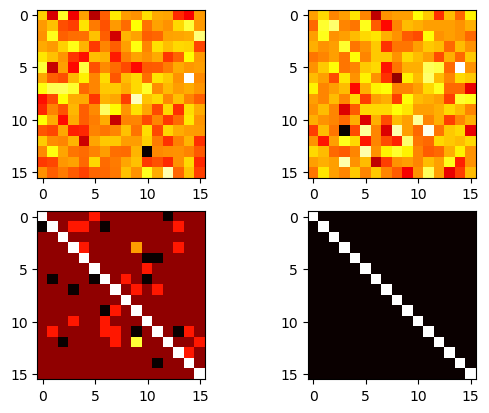

In [5]:
disclaputest = discLapU(device)
fig, axs = plt.subplots(2,2)
disclaputest.privatize(data_disc, n_category, 0.1)
axs[0,0].imshow(disclaputest.privatize(data_disc, n_category, 0.1), cmap = 'hot', interpolation = 'nearest')
axs[0,1].imshow(disclaputest.privatize(data_disc, n_category, 1.0), cmap = 'hot', interpolation = 'nearest')
axs[1,0].imshow(disclaputest.privatize(data_disc, n_category, 10), cmap = 'hot', interpolation = 'nearest')
axs[1,1].imshow(disclaputest.privatize(data_disc, n_category, 1000), cmap = 'hot', interpolation = 'nearest')

In [50]:
torch.multinomial(torch.tensor([1/2,1/2]), 1)

tensor([0])

In [24]:
weights = torch.tensor([0, 10, 3, 0], dtype=torch.float) # create a tensor of weights
multi = torch.multinomial(weights, 2)
 return(torch.nn.functional.one_hot(data_multinomial, alphabet_size))

IndentationError: unexpected indent (2434617784.py, line 3)

tensor([3, 1, 1, 0])

In [ ]:
torch.nn.functional.one_hot(multi_sample, 4)

RuntimeError: Class values must be smaller than num_classes.